In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
import optuna
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import shap
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv(r"C:\Users\elias\Downloads\Data Management\df_without_budget.csv")
df

,adult,runtime,is_top_actor_movie,lang_ab,lang_af,lang_ar,lang_bg,lang_bm,lang_bn,lang_bo,...,production_country_ZW,production_country_notfound,continent_AF,continent_AS,continent_EU,continent_NA,continent_OC,continent_SA,continent_UNKNOWN,is_top_company_movie
0,False,81.0,0,False,False,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,1
1,False,104.0,0,False,False,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,0
2,False,101.0,0,False,False,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,1
3,False,127.0,0,False,False,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,0
4,False,106.0,0,False,False,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15458,False,45.0,0,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,1,0
15459,False,30.0,0,False,False,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,0
15460,False,85.0,0,False,False,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,0
15461,False,104.0,0,False,False,False,False,False,False,False,...,0,0,0,0,1,1,0,0,0,0


In [4]:
X = df.drop(['recommend'],axis=1)
X = X.astype('float64')
y = df['recommend']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Imputing remaining missing values

In [9]:
nulls = pd.DataFrame(df.isnull().sum())
nulls[nulls[0] > 0]

,0
runtime,95
release_year,28
release_month,28
release_dayofweek,28


Runtime --> impute the mean <br>
Year/Month/DayOfWeek --> impute mode

In [6]:
df['release_year'].describe()

count    15435.000000
mean      1997.915128
std         12.951542
min       1888.000000
25%       1995.000000
50%       2001.000000
75%       2005.000000
max       2017.000000
Name: release_year, dtype: float64

In [7]:
def impute_nans(passed_X): 
    passed_X['runtime'].fillna(X_train['runtime'].mean(), inplace=True)
    passed_X['release_year'].fillna(X_train['release_year'].mode().iloc[0].astype(int), inplace=True)
    passed_X['release_month'].fillna(X_train['release_month'].mode().iloc[0].astype(int), inplace=True)
    passed_X['release_dayofweek'].fillna(X_train['release_dayofweek'].mode().iloc[0].astype(int), inplace=True)
    return passed_X

In [8]:
X_train = impute_nans(X_train)
X_test = impute_nans(X_test)

### DECISION TREE

### LOGISTIC REGRESSION

### k-Nearest Neighbor

### XGBOOST

In [ ]:
def build_xgb_model(trial):
    
    params = {
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'n_jobs': -1,
        'tree_method': 'hist',
        'random_state': 42,
        'verbosity': 0
    }
    

    
    return xgb.XGBClassifier(**params)

In [ ]:
def objective(trial, X_train, y_train, X_val, y_val):
    """
    Optuna objective function for XGBClassifier.
    It builds the model, trains it, and returns the Log Loss (to be minimized).
    """
    # 1. Build the model with the current trial's hyperparameters
    # Assumes 'build_xgb_classifier_model' is defined and returns an xgb.XGBClassifier
    model = build_xgb_model(trial) 

    # 2. Train the model
    # We use early stopping to prevent overfitting during the trial
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)], # Use logloss as the metric for early stopping
        verbose=False
    )

    # 3. Predict probabilities on the validation set
    # We use predict_proba to get the probabilities required for log_loss
    # We take the probability of the positive class (column 1)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # 4. Calculate the Mean Log Loss
    # This is the value Optuna will try to minimize
    logloss = log_loss(y_val, y_pred_proba)

    return logloss

In [ ]:
def train_best_model(X_train, y_train, n_trials=200,):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(directions=["minimize"])
    
    study.optimize(
        lambda trial: objective(trial, X_train, y_train, X_val, y_val), 
        n_trials=n_trials
    )
    
    # Train final models with best parameters
    best_params = study.best_trials[0].params
    
    model_mean = build_xgb_model(
        optuna.trial.FixedTrial(best_params)
        
    ).fit(X, y)
    #Calculate Shapley value to calculate feature importance.
    explainer = shap.Explainer(model_mean, X_train)

    # Calculate SHAP values
    shap_values = explainer(X_val)
    shap.summary_plot(shap_values, features=X_val)
    
    return model_mean, study

In [ ]:

model_classifier, study = train_best_model(X_train, y_train, n_trials=50)

# 3. Update the print statements
print("Optimal classifier model is: ", model_classifier)

# 4. Print the correct optimized metric value from the study
# If optimizing for Log Loss (minimization):
print("The Log Loss of this model is: ", study.best_value)

In [ ]:
model_classifier.score(X_test, y_test)

In [ ]:
y_pred = model_classifier.predict(X_test)

In [ ]:
# 2. Calculate the raw confusion matrix values
cm = confusion_matrix(y_test, y_pred)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    cbar=False,
    # If your labels are multi-class, you should define class labels here
    # xticklabels=opt.classes_, 
    # yticklabels=opt.classes_
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Random Forest Classifier

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train, random_state = 42)

print("Best Parameters:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)

Best Parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Estimator: RandomForestClassifier(max_depth=20, min_samples_leaf=2)


In [18]:
y_pred = grid_search.best_estimator_.predict(X_test)

Accuracy: 67.41%


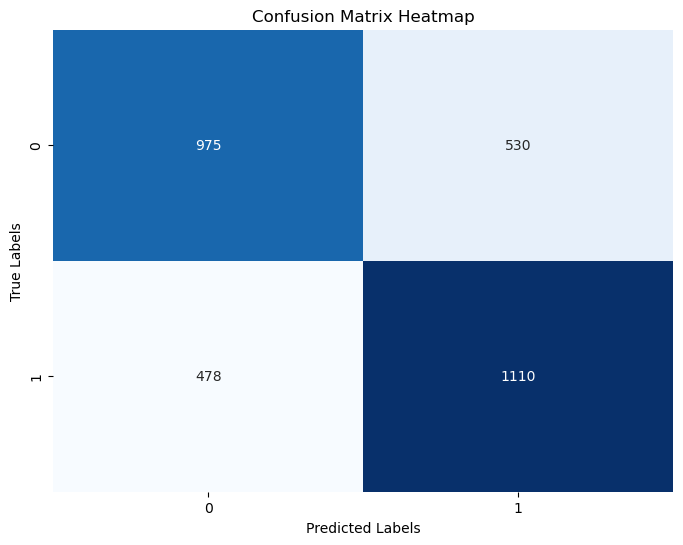

In [19]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()